In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from solver_linear import Solver, Method
from norms import norm_vec, NormType

plt.style.use("ggplot")

In [2]:
def create_polynomial(coefficients):
    """Создает полиномиальную функцию с заданными коэффициентами"""
    def polynomial(x):
        result = 0
        for i, coef in enumerate(coefficients):
            result += coef * x**i
        return result
    return polynomial

def create_func(coefficients, basis):
    """Создает функцию по данному базису с заданными коэффициентами"""
    def func(x):
        result = 0
        for i, coef in enumerate(coefficients):
            result += coef * basis[i](x)
        return result
    return func

def create_sin_basis(k):
    """Создаем функцию вида sin(k*x), где k - некий коэффициент"""
    def polynomial(x):
        return np.sin(k * x)
    return polynomial

## Алгоритм интерполяции по базису и "опорным" точкам

In [3]:
def calc_A(x_array, basis):
    dim = len(basis)
    # Создаем матрицу, где каждая строка соответствует элементу x_array, а столбцы - значениям базисных функций
    result_matrix = np.zeros((len(x_array), dim))
    for i in range(dim):
        result_matrix[:, i] = basis[i](x_array)
    return result_matrix

def interpolate(x, f, basis=None):
    n = len(x)
    if basis is None:
        # Если не задан базис, то это полиномы степени не выше n
        ed = np.eye(n)
        basis = [create_polynomial(ed[:,i]) for i in range(n)]
    
    # Матрица A для CЛАУ
    A = calc_A(x, basis)
    # Коэффициенты a
    sl = Solver()
    # if np.linalg.det(A) < 10e-16:
        # raise RuntimeWarning("Determinant matrix A < 10e-16!!!")
    a = sl.solve(A, f[..., None], method=Method.GAUSS_TWO)
    return create_func(a, basis)



### Функция подсчета ошибки
### Ошибка - норма бесконечности

In [4]:
from scipy.integrate import quad

def error(f, F, x):
    return norm_vec(f(x) - F(x), NormType.INF)

def error_integrate(f, F, x):
    sum_err = 0
    for i in range(x.shape[0] - 1):
        I, err = quad(lambda x: f(x) - F(x), x[i], x[i+1])
        sum_err += np.absolute(I)
    return sum_err

## Интерполяция куба полиномами

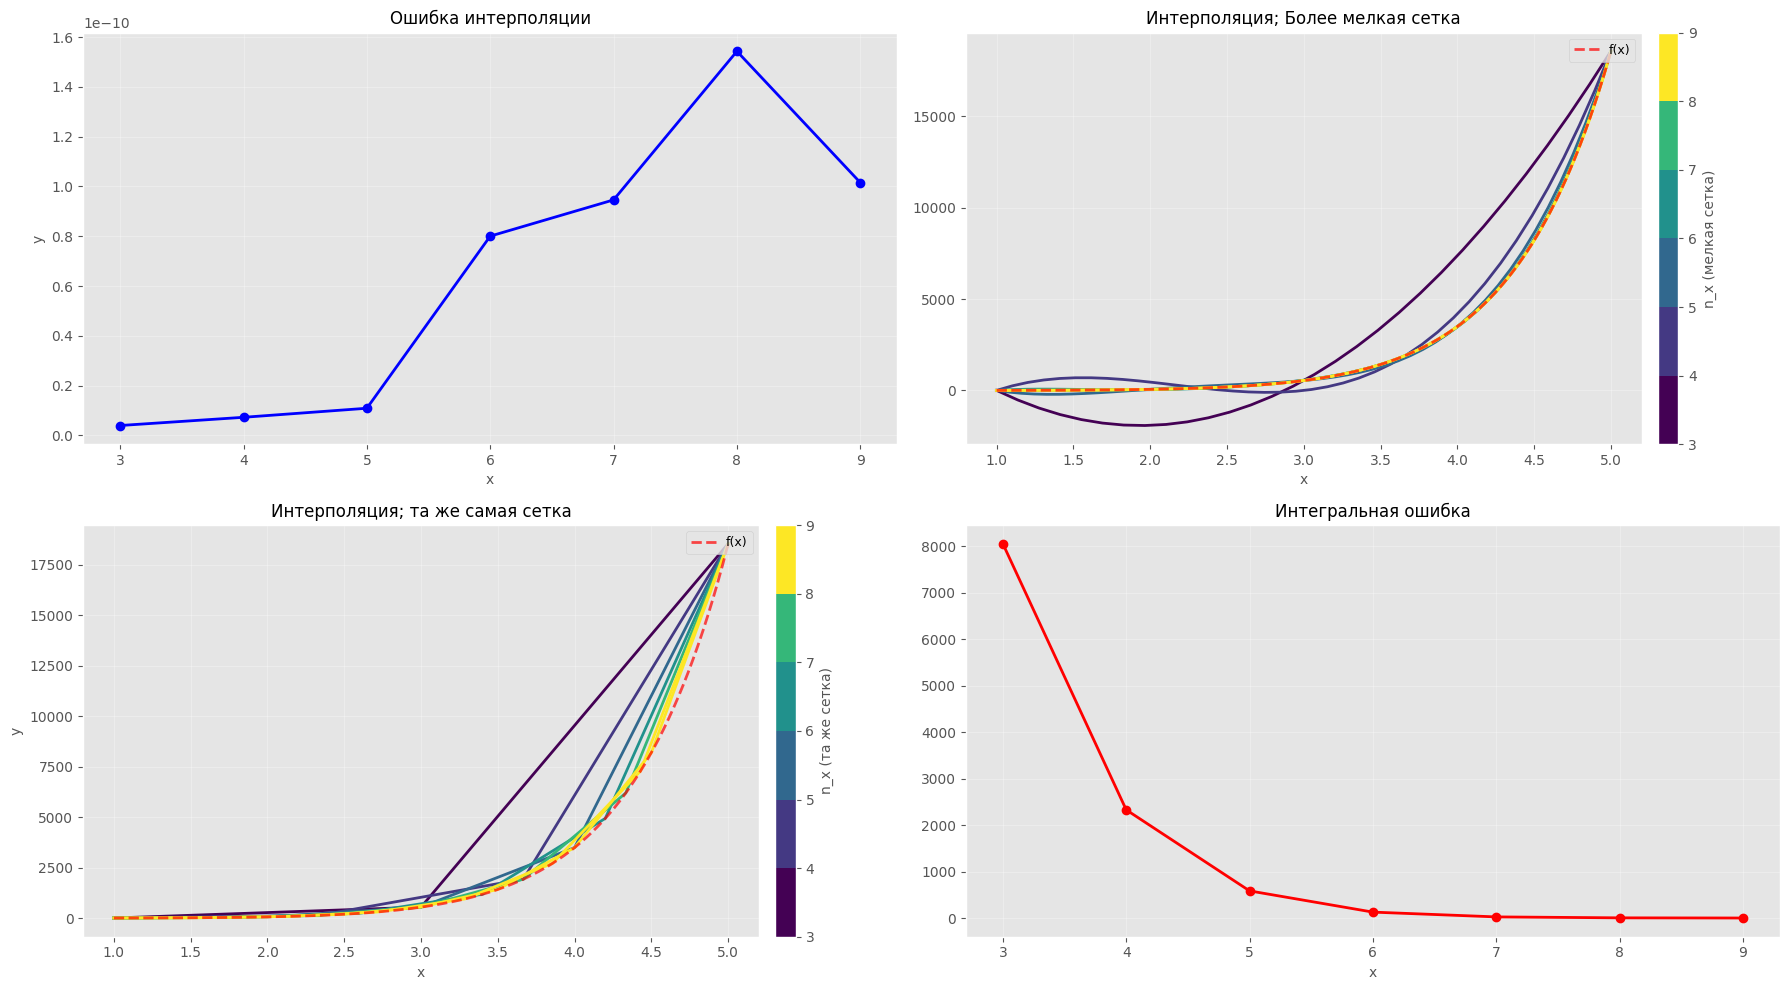

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

f = lambda x: x**3 * np.exp(x)

x_max, x_min, step = 10, 3, 1
N_x = np.arange(x_min, x_max, step, dtype=int)

# Создание дискретной цветовой карты
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(N_x)))
discrete_cmap = ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(N_x, discrete_cmap.N)

ERROR = []
ERROR_INTEGRATE = []

x_l = 1
x_r = 5
for n_x in N_x:

    x = np.linspace(x_l, x_r, n_x)
    x_new = np.linspace(x_l, x_r, n_x*10)
    pl = pl = interpolate(x, f(x))
    
    color = discrete_cmap(norm(n_x))
    
    # Более мелкая сетка
    axes[0][1].plot(x_new, pl(x_new), color=color, linewidth=2)
    # Та же сетка, что для интерполяции
    axes[1][0].plot(x, pl(x), color=color, linewidth=2)
    
    ERROR.append(error(f, pl, x))
    ERROR_INTEGRATE.append(error_integrate(f, pl, x))

# Добавляем исходную функцию
x_dense = np.linspace(x_l, x_r, 1000)
axes[0][1].plot(x_dense, f(x_dense), 'r--', linewidth=2, alpha=0.7, label='f(x)')
axes[1][0].plot(x_dense, f(x_dense), 'r--', linewidth=2, alpha=0.7, label='f(x)')

# Добавляем цветовые шкалы
cbar1 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=discrete_cmap),
                    ax=axes[0][1], orientation='vertical', pad=0.02)
cbar1.set_label('n_x (мелкая сетка)', fontsize=10)
cbar1.set_ticks(N_x)

cbar2 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=discrete_cmap),
                    ax=axes[1][0], orientation='vertical', pad=0.02)
cbar2.set_label('n_x (та же сетка)', fontsize=10)
cbar2.set_ticks(N_x)

# Настройка заголовков и осей
axes[0][1].set_title("Интерполяция; Более мелкая сетка", fontsize=12)
axes[0][0].set_title("Ошибка интерполяции", fontsize=12)
axes[1][0].set_title("Интерполяция; та же самая сетка", fontsize=12)
axes[1][1].set_title("Интегральная ошибка", fontsize=12)

# Построение графиков ошибок
axes[0][0].plot(N_x, np.abs(ERROR), 'bo-', linewidth=2, markersize=6)
# axes[0][0].set_yscale('log')
axes[1][1].plot(N_x, ERROR_INTEGRATE, 'ro-', linewidth=2, markersize=6)

# Добавляем сетку и подписи осей
for i in range(2):
    for j in range(2):
        axes[i][j].grid(alpha=0.3)
        axes[i][j].set_xlabel('x', fontsize=10)
        if j == 0:
            axes[i][j].set_ylabel('y', fontsize=10)

# Добавляем легенду для исходной функции
axes[0][1].legend(loc='upper right', fontsize=9)
axes[1][0].legend(loc='upper right', fontsize=9)


plt.tight_layout()
plt.show()

## Интерполяция куба синусами

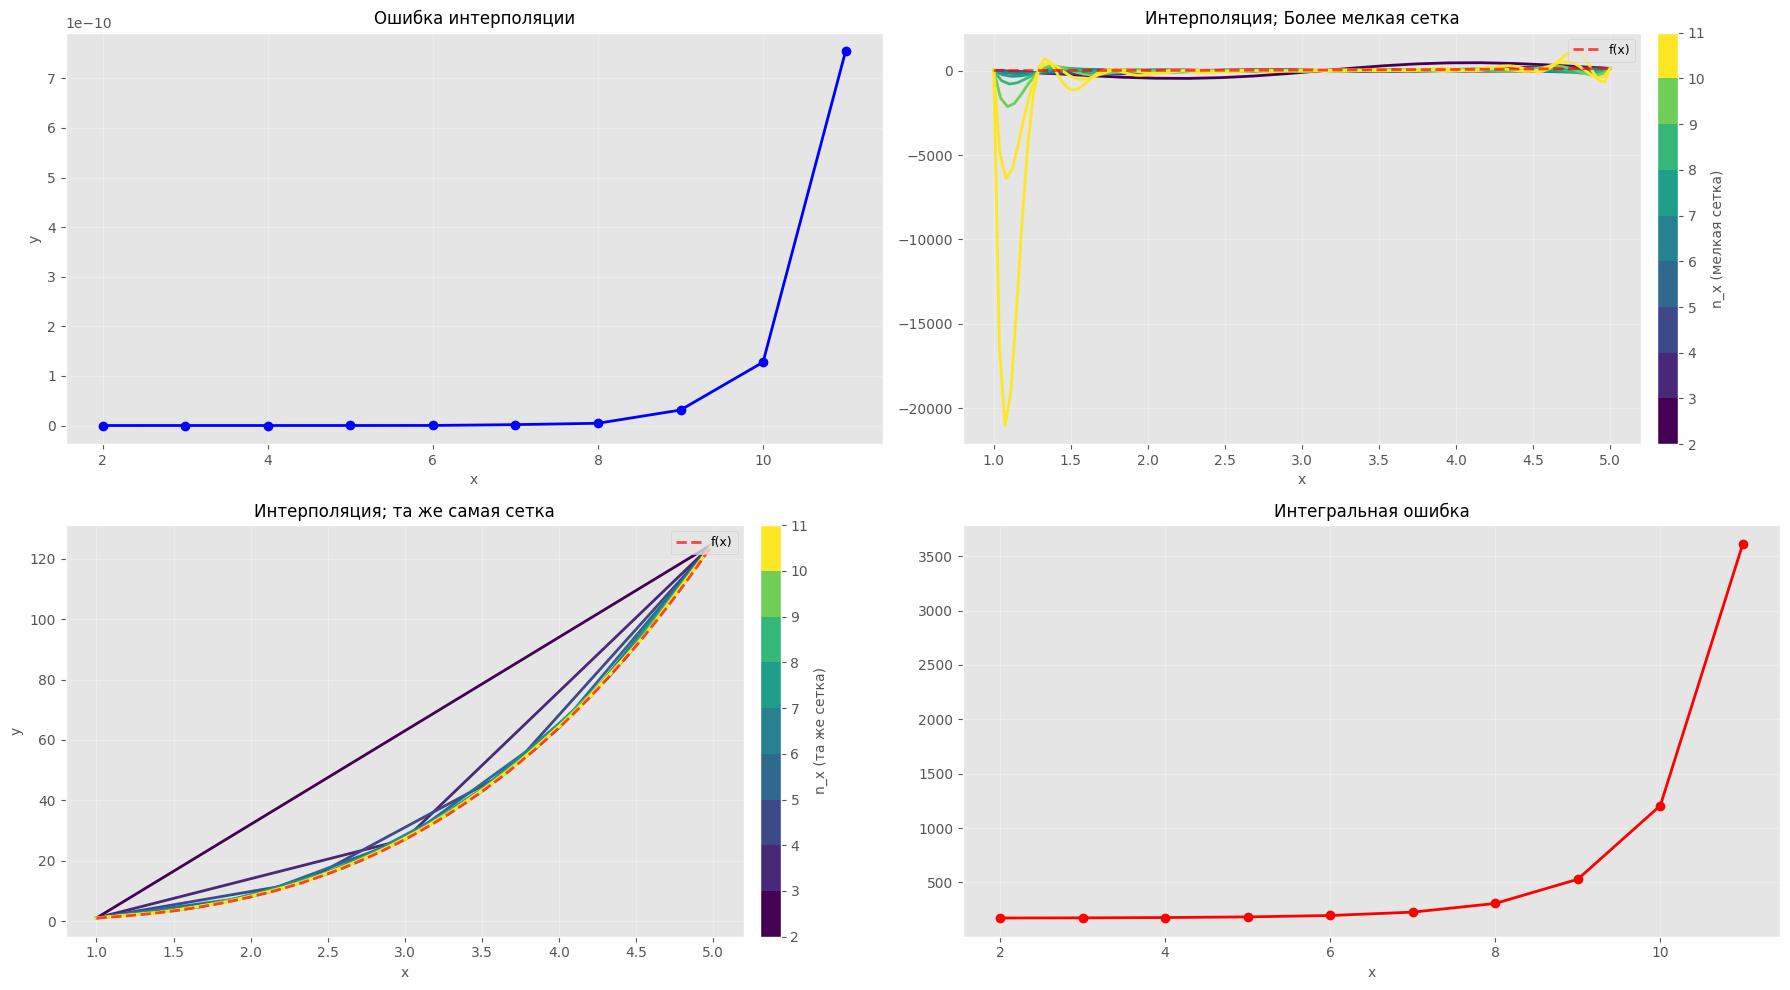

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

f = lambda x: x**3

N_max, N_min, N_step = 12, 2, 1
N_x = np.arange(N_min, N_max, N_step, dtype=int)

# Создание дискретной цветовой карты
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(N_x)))
discrete_cmap = ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(N_x, discrete_cmap.N)

ERROR = []
ERROR_INTEGRATE = []

x_l = 1
x_r = 5
for n_x in N_x:

    x = np.linspace(x_l, x_r, n_x)
    x_new = np.linspace(x_l, x_r, n_x*10)
    basis = [create_sin_basis(k) for k in range(1, x.shape[0]+1)]
    pl = interpolate(x, f(x), basis=basis)
    
    color = discrete_cmap(norm(n_x))
    
    # Более мелкая сетка
    axes[0][1].plot(x_new, pl(x_new), color=color, linewidth=2)
    # Та же сетка, что для интерполяции
    axes[1][0].plot(x, pl(x), color=color, linewidth=2)
    
    ERROR.append(error(f, pl, x))
    ERROR_INTEGRATE.append(error_integrate(f, pl, x))

# Добавляем исходную функцию
x_dense = np.linspace(x_l, x_r, 1000)
axes[0][1].plot(x_dense, f(x_dense), 'r--', linewidth=2, alpha=0.7, label='f(x)')
axes[1][0].plot(x_dense, f(x_dense), 'r--', linewidth=2, alpha=0.7, label='f(x)')

# Добавляем цветовые шкалы
cbar1 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=discrete_cmap),
                    ax=axes[0][1], orientation='vertical', pad=0.02)
cbar1.set_label('n_x (мелкая сетка)', fontsize=10)
cbar1.set_ticks(N_x)

cbar2 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=discrete_cmap),
                    ax=axes[1][0], orientation='vertical', pad=0.02)
cbar2.set_label('n_x (та же сетка)', fontsize=10)
cbar2.set_ticks(N_x)

# Настройка заголовков и осей
axes[0][1].set_title("Интерполяция; Более мелкая сетка", fontsize=12)
axes[0][0].set_title("Ошибка интерполяции", fontsize=12)
axes[1][0].set_title("Интерполяция; та же самая сетка", fontsize=12)
axes[1][1].set_title("Интегральная ошибка", fontsize=12)

# Построение графиков ошибок
axes[0][0].plot(N_x, ERROR, 'bo-', linewidth=2, markersize=6)
axes[1][1].plot(N_x, ERROR_INTEGRATE, 'ro-', linewidth=2, markersize=6)

# Добавляем сетку и подписи осей
for i in range(2):
    for j in range(2):
        axes[i][j].grid(alpha=0.3)
        axes[i][j].set_xlabel('x', fontsize=10)
        if j == 0:
            axes[i][j].set_ylabel('y', fontsize=10)

# Добавляем легенду для исходной функции
axes[0][1].legend(loc='upper right', fontsize=9)
axes[1][0].legend(loc='upper right', fontsize=9)


plt.tight_layout()
plt.show()

## Интерполяционный многочлен Лагранжа

In [13]:
# Интерполяционный многочлен Лагранжа
def Lagrange_polynomial(x_array, f):

    def l_p(x):
        L_p = 0
        for k in range(x_array.shape[0]):
            tmp = 1
            for i in range(x_array.shape[0]):
                if(i != k):
                    tmp *= (x - x_array[i]) / (x_array[k] - x_array[i])
            L_p += f[k] * tmp

        return L_p
    return l_p

## Интерполяция куба многочленом Лагранжа

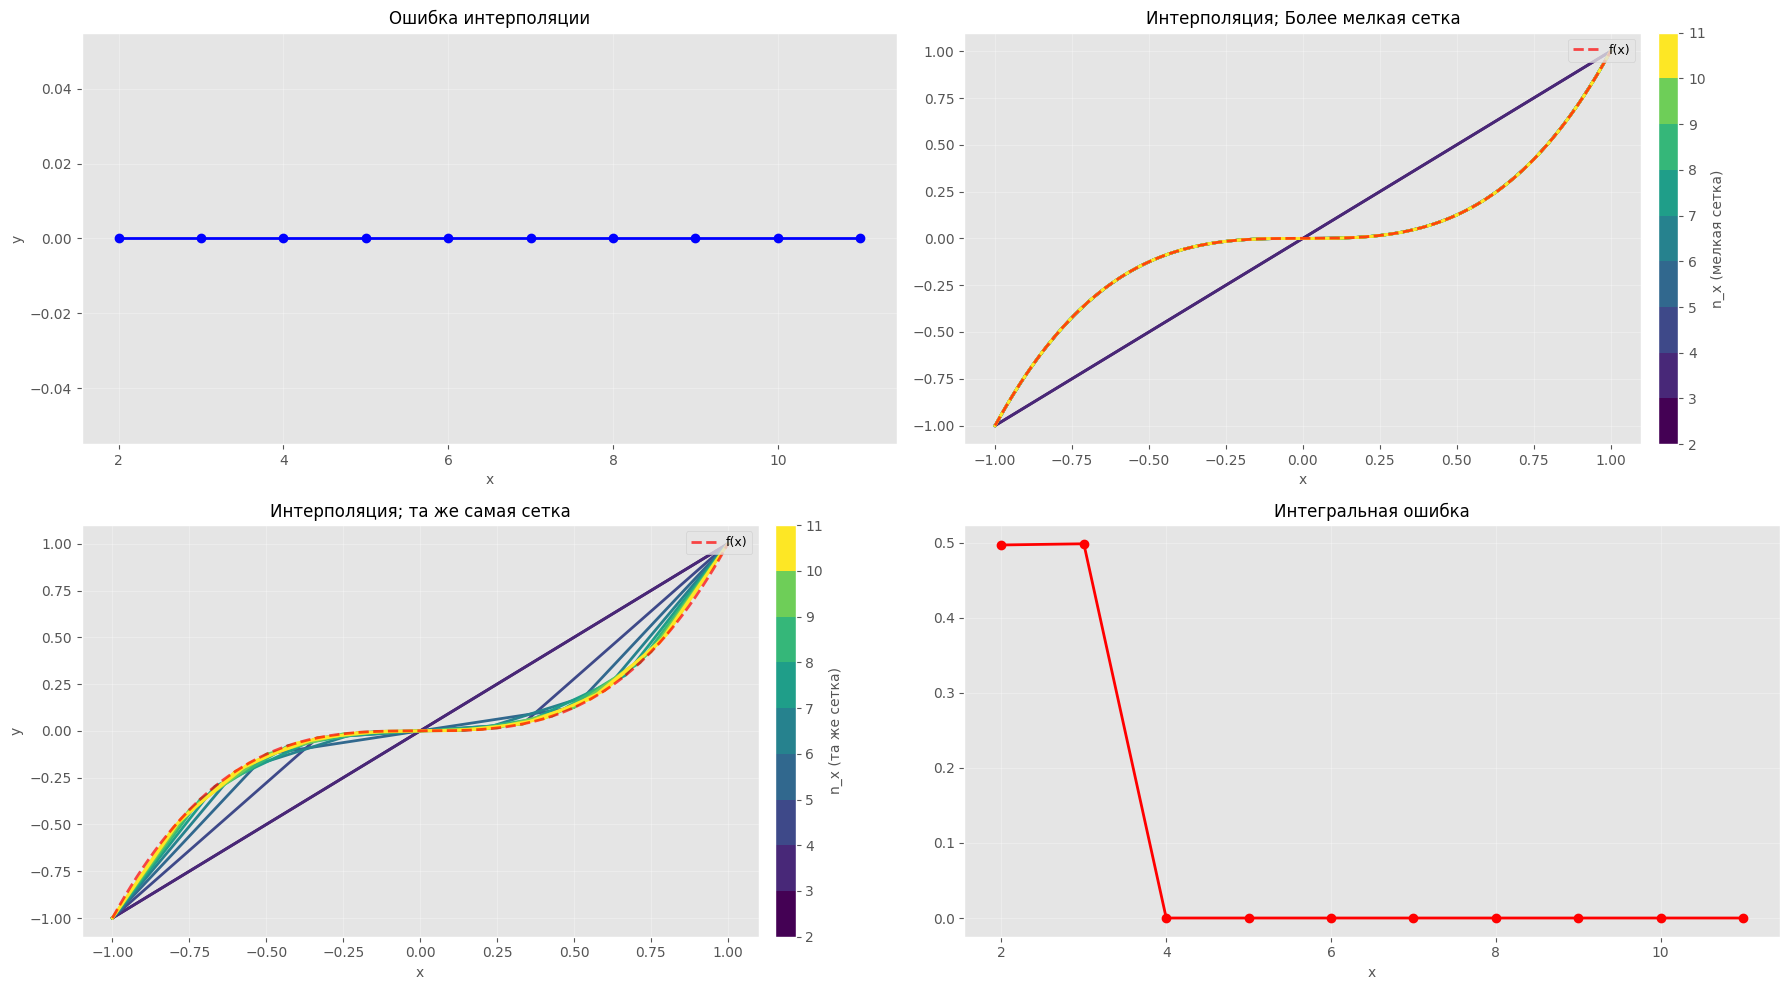

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

f = lambda x: x**3

N_max, N_min, N_step = 12, 2, 1
N_x = np.arange(N_min, N_max, N_step, dtype=int)

# Создание дискретной цветовой карты
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(N_x)))
discrete_cmap = ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(N_x, discrete_cmap.N)

ERROR = []
ERROR_INTEGRATE = []

for n_x in N_x:
    x = np.linspace(-1, 1, n_x)
    l_p = Lagrange_polynomial(x, f(x))
    x_new = np.linspace(-1, 1, n_x*10)
    
    color = discrete_cmap(norm(n_x))
    
    # Более мелкая сетка
    axes[0][1].plot(x_new, l_p(x_new), color=color, linewidth=2)
    # Та же сетка, что для интерполяции
    axes[1][0].plot(x, l_p(x), color=color, linewidth=2)
    
    ERROR.append(error(f, l_p, x))
    ERROR_INTEGRATE.append(error_integrate(f, l_p, x_new))

# Добавляем исходную функцию
x_dense = np.linspace(-1, 1, 1000)
axes[0][1].plot(x_dense, f(x_dense), 'r--', linewidth=2, alpha=0.7, label='f(x)')
axes[1][0].plot(x_dense, f(x_dense), 'r--', linewidth=2, alpha=0.7, label='f(x)')

# Добавляем цветовые шкалы
cbar1 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=discrete_cmap),
                    ax=axes[0][1], orientation='vertical', pad=0.02)
cbar1.set_label('n_x (мелкая сетка)', fontsize=10)
cbar1.set_ticks(N_x)

cbar2 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=discrete_cmap),
                    ax=axes[1][0], orientation='vertical', pad=0.02)
cbar2.set_label('n_x (та же сетка)', fontsize=10)
cbar2.set_ticks(N_x)

# Настройка заголовков и осей
axes[0][1].set_title("Интерполяция; Более мелкая сетка", fontsize=12)
axes[0][0].set_title("Ошибка интерполяции", fontsize=12)
axes[1][0].set_title("Интерполяция; та же самая сетка", fontsize=12)
axes[1][1].set_title("Интегральная ошибка", fontsize=12)

# Построение графиков ошибок
axes[0][0].plot(N_x, ERROR, 'bo-', linewidth=2, markersize=6)
axes[1][1].plot(N_x, ERROR_INTEGRATE, 'ro-', linewidth=2, markersize=6)

# Добавляем сетку и подписи осей
for i in range(2):
    for j in range(2):
        axes[i][j].grid(alpha=0.3)
        axes[i][j].set_xlabel('x', fontsize=10)
        if j == 0:
            axes[i][j].set_ylabel('y', fontsize=10)

# Добавляем легенду для исходной функции
axes[0][1].legend(loc='upper right', fontsize=9)
axes[1][0].legend(loc='upper right', fontsize=9)


plt.tight_layout()
plt.show()

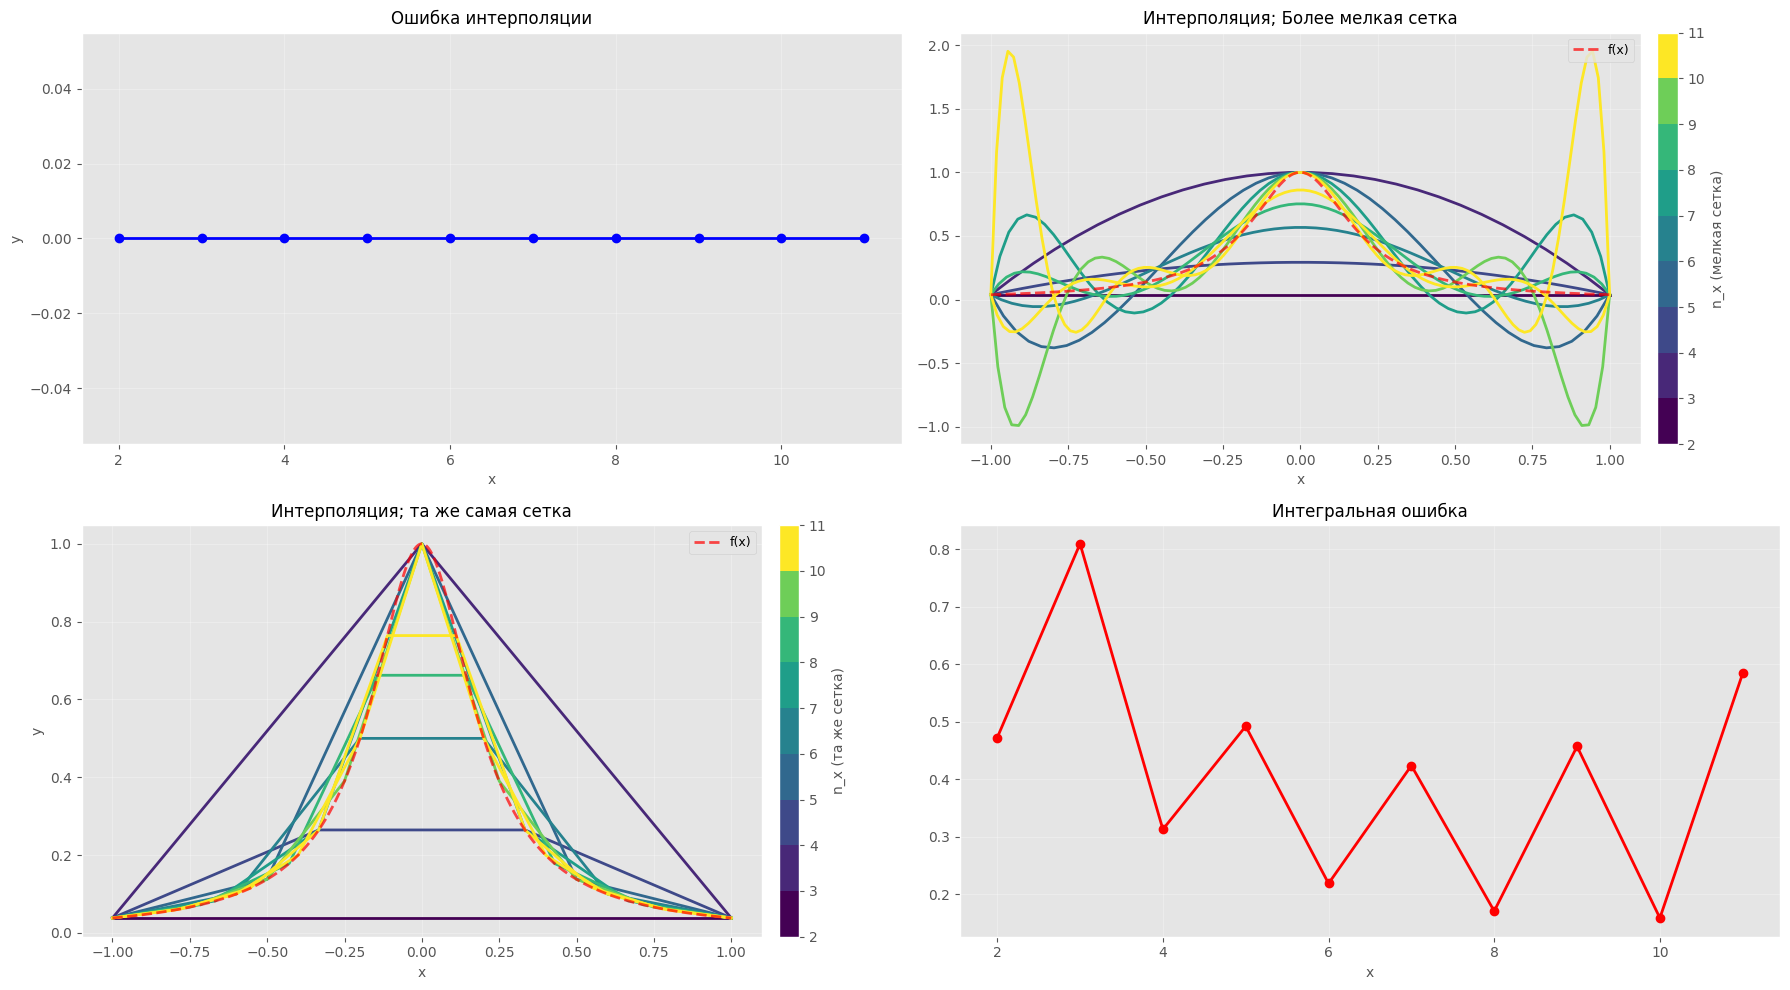

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

def f(x):
    return 1/(1+25*x**2)

N_max, N_min, N_step = 12, 2, 1
N_x = np.arange(N_min, N_max, N_step, dtype=int)

# Создание дискретной цветовой карты
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(N_x)))
discrete_cmap = ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(N_x, discrete_cmap.N)

ERROR = []
ERROR_INTEGRATE = []

for n_x in N_x:
    x = np.linspace(-1, 1, n_x)
    l_p = Lagrange_polynomial(x, f(x))
    x_new = np.linspace(-1, 1, n_x*10)
    
    color = discrete_cmap(norm(n_x))
    
    # Более мелкая сетка
    axes[0][1].plot(x_new, l_p(x_new), color=color, linewidth=2)
    # Та же сетка, что для интерполяции
    axes[1][0].plot(x, l_p(x), color=color, linewidth=2)
    
    ERROR.append(error(f, l_p, x))
    ERROR_INTEGRATE.append(error_integrate(f, l_p, x))

# Добавляем исходную функцию
x_dense = np.linspace(-1, 1, 1000)
axes[0][1].plot(x_dense, f(x_dense), 'r--', linewidth=2, alpha=0.7, label='f(x)')
axes[1][0].plot(x_dense, f(x_dense), 'r--', linewidth=2, alpha=0.7, label='f(x)')

# Добавляем цветовые шкалы
cbar1 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=discrete_cmap),
                    ax=axes[0][1], orientation='vertical', pad=0.02)
cbar1.set_label('n_x (мелкая сетка)', fontsize=10)
cbar1.set_ticks(N_x)

cbar2 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=discrete_cmap),
                    ax=axes[1][0], orientation='vertical', pad=0.02)
cbar2.set_label('n_x (та же сетка)', fontsize=10)
cbar2.set_ticks(N_x)

# Настройка заголовков и осей
axes[0][1].set_title("Интерполяция; Более мелкая сетка", fontsize=12)
axes[0][0].set_title("Ошибка интерполяции", fontsize=12)
axes[1][0].set_title("Интерполяция; та же самая сетка", fontsize=12)
axes[1][1].set_title("Интегральная ошибка", fontsize=12)

# Построение графиков ошибок
axes[0][0].plot(N_x, ERROR, 'bo-', linewidth=2, markersize=6)
axes[1][1].plot(N_x, ERROR_INTEGRATE, 'ro-', linewidth=2, markersize=6)

# Добавляем сетку и подписи осей
for i in range(2):
    for j in range(2):
        axes[i][j].grid(alpha=0.3)
        axes[i][j].set_xlabel('x', fontsize=10)
        if j == 0:
            axes[i][j].set_ylabel('y', fontsize=10)

# Добавляем легенду для исходной функции
axes[0][1].legend(loc='upper right', fontsize=9)
axes[1][0].legend(loc='upper right', fontsize=9)


plt.tight_layout()
plt.show()